# MongoDB ObjectId DateTime Proof

Este notebook demonstra que o ObjectId do MongoDB contém um timestamp embutido.
Vamos provar que documentos inseridos posteriormente têm ObjectIds com timestamps mais recentes.

## Conceito do ObjectId

O ObjectId do MongoDB é um identificador de 12 bytes com a seguinte estrutura:
- **Bytes 0-3**: Timestamp Unix (segundos desde epoch)
- **Bytes 4-6**: Identificador da máquina
- **Bytes 7-8**: Process ID
- **Bytes 9-11**: Contador incremental

## Setup e Importações

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# URL base da API
BASE_URL = 'http://localhost:8000'

print('✅ Setup completo!')

✅ Setup completo!


## Funções Auxiliares

In [2]:
def check_api_health():
    """Verifica se a API e o MongoDB estão funcionando."""
    try:
        response = requests.get(f'{BASE_URL}/health')
        data = response.json()
        if data['status'] == 'healthy':
            print('✅ API está saudável e MongoDB conectado!')
            return True
        else:
            print(f'❌ API não está saudável: {data}')
            return False
    except Exception as e:
        print(f'❌ Erro ao conectar à API: {e}')
        return False

def clear_documents():
    """Limpa todos os documentos do banco."""
    response = requests.delete(f'{BASE_URL}/documents')
    data = response.json()
    print(f"🗑️ {data['deleted_count']} documentos deletados")

def insert_single_document(name: str):
    """Insere um único documento."""
    response = requests.post(f'{BASE_URL}/documents', json={'name': name})
    return response.json()

def insert_batch(count: int, delay_ms: int = 0, prefix: str = 'doc'):
    """Insere múltiplos documentos com delay opcional."""
    response = requests.post(f'{BASE_URL}/documents/batch', json={
        'count': count,
        'delay_ms': delay_ms,
        'prefix': prefix
    })
    return response.json()

def get_all_documents():
    """Recupera todos os documentos."""
    response = requests.get(f'{BASE_URL}/documents')
    return response.json()

def compare_first_last():
    """Compara o primeiro e último documento."""
    response = requests.get(f'{BASE_URL}/documents/compare-first-last')
    return response.json()

# Verificar conexão
check_api_health()

✅ API está saudável e MongoDB conectado!


True

---
# Experimento 1: Inserção com Delay

Vamos inserir 10 documentos com 1 segundo de delay entre cada um para demonstrar claramente que os ObjectIds têm timestamps diferentes.

In [3]:
# Limpar banco antes do experimento
clear_documents()

# Inserir 10 documentos com 1 segundo de delay
print('⏳ Inserindo 10 documentos com 1 segundo de delay...')
docs_with_delay = insert_batch(count=10, delay_ms=1000, prefix='delay_test')
print(f'✅ {len(docs_with_delay)} documentos inseridos!')

# Criar DataFrame
df_delay = pd.DataFrame(docs_with_delay)
df_delay['generation_time'] = pd.to_datetime(df_delay['generation_time'])
df_delay['index'] = range(1, len(df_delay) + 1)

df_delay[['index', 'name', '_id', 'generation_time']]

🗑️ 6 documentos deletados
⏳ Inserindo 10 documentos com 1 segundo de delay...
✅ 10 documentos inseridos!


,index,name,_id,generation_time
0,1,delay_test_1,693e6c63df1e23609fef47f1,2025-12-14 07:50:59+00:00
1,2,delay_test_2,693e6c64df1e23609fef47f2,2025-12-14 07:51:00+00:00
2,3,delay_test_3,693e6c65df1e23609fef47f3,2025-12-14 07:51:01+00:00
3,4,delay_test_4,693e6c66df1e23609fef47f4,2025-12-14 07:51:02+00:00
4,5,delay_test_5,693e6c67df1e23609fef47f5,2025-12-14 07:51:03+00:00
5,6,delay_test_6,693e6c68df1e23609fef47f6,2025-12-14 07:51:04+00:00
6,7,delay_test_7,693e6c69df1e23609fef47f7,2025-12-14 07:51:05+00:00
7,8,delay_test_8,693e6c6adf1e23609fef47f8,2025-12-14 07:51:06+00:00
8,9,delay_test_9,693e6c6bdf1e23609fef47f9,2025-12-14 07:51:07+00:00
9,10,delay_test_10,693e6c6cdf1e23609fef47fa,2025-12-14 07:51:08+00:00


/var/folders/nn/4459bvg541j38p1n83wq2qm40000gn/T/ipykernel_12020/3294376811.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


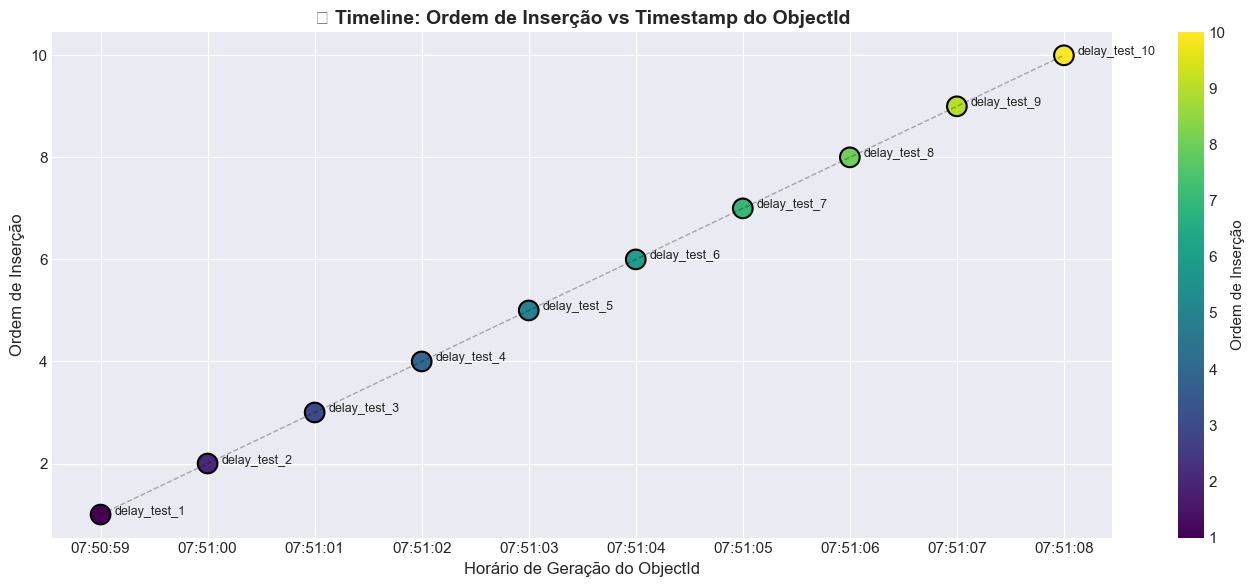


✅ PROVA: Documentos inseridos depois têm timestamps mais recentes!


In [4]:
# Visualização 1: Timeline dos ObjectIds
fig, ax = plt.subplots(figsize=(14, 6))

# Plot timeline
colors = plt.cm.viridis(df_delay['index'] / df_delay['index'].max())
scatter = ax.scatter(df_delay['generation_time'], df_delay['index'], 
                     c=df_delay['index'], cmap='viridis', s=200, edgecolors='black', linewidths=1.5)

# Conectar pontos com linha
ax.plot(df_delay['generation_time'], df_delay['index'], 'k--', alpha=0.3, linewidth=1)

# Labels
for i, row in df_delay.iterrows():
    ax.annotate(row['name'], (row['generation_time'], row['index']), 
                textcoords='offset points', xytext=(10, 0), fontsize=9)

ax.set_xlabel('Horário de Geração do ObjectId', fontsize=12)
ax.set_ylabel('Ordem de Inserção', fontsize=12)
ax.set_title('📊 Timeline: Ordem de Inserção vs Timestamp do ObjectId', fontsize=14, fontweight='bold')

plt.colorbar(scatter, label='Ordem de Inserção')
plt.tight_layout()
plt.show()

print('\n✅ PROVA: Documentos inseridos depois têm timestamps mais recentes!')

---
# Experimento 2: Comparação Primeiro vs Último

Comparação direta entre o primeiro documento inserido e o último.

In [5]:
# Comparar primeiro e último
comparison = compare_first_last()

print('📋 COMPARAÇÃO PRIMEIRO vs ÚLTIMO DOCUMENTO')
print('=' * 60)
print(f"\n🥇 PRIMEIRO DOCUMENTO:")
print(f"   ID: {comparison['first_document']['_id']}")
print(f"   Timestamp: {comparison['first_document']['generation_time']}")

print(f"\n🥈 ÚLTIMO DOCUMENTO:")
print(f"   ID: {comparison['last_document']['_id']}")
print(f"   Timestamp: {comparison['last_document']['generation_time']}")

print(f"\n⏱️ DIFERENÇA DE TEMPO: {comparison['time_difference_seconds']:.2f} segundos")
print(f"\n✅ {comparison['proof']}")

📋 COMPARAÇÃO PRIMEIRO vs ÚLTIMO DOCUMENTO

🥇 PRIMEIRO DOCUMENTO:
   ID: 693e6c63df1e23609fef47f1
   Timestamp: 2025-12-14T07:50:59+00:00

🥈 ÚLTIMO DOCUMENTO:
   ID: 693e6c6cdf1e23609fef47fa
   Timestamp: 2025-12-14T07:51:08+00:00

⏱️ DIFERENÇA DE TEMPO: 9.00 segundos

✅ The last inserted ObjectId has a more recent timestamp


/var/folders/nn/4459bvg541j38p1n83wq2qm40000gn/T/ipykernel_12020/3739093839.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()


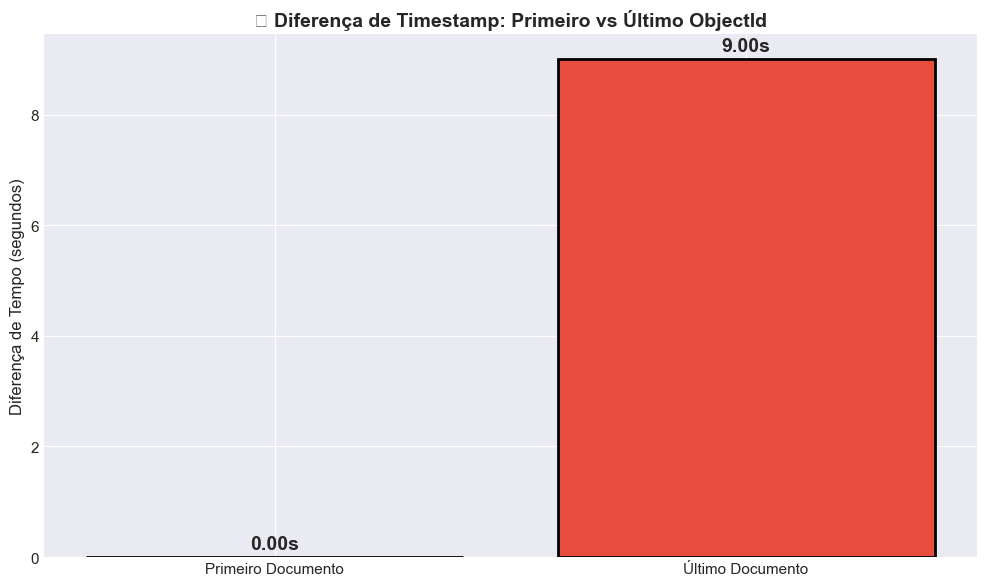


✅ O último documento foi inserido 9.00 segundos depois do primeiro!


In [6]:
# Visualização 2: Bar Chart Comparativo
fig, ax = plt.subplots(figsize=(10, 6))

first_ts = comparison['first_document']['generation_time_timestamp']
last_ts = comparison['last_document']['generation_time_timestamp']

# Normalizar para mostrar diferença relativa
bar_data = ['Primeiro Documento', 'Último Documento']
bar_values = [0, last_ts - first_ts]
bar_colors = ['#2ecc71', '#e74c3c']

bars = ax.bar(bar_data, bar_values, color=bar_colors, edgecolor='black', linewidth=2)

# Adicionar valores nas barras
for bar, val in zip(bars, bar_values):
    height = bar.get_height()
    ax.annotate(f'{val:.2f}s',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Diferença de Tempo (segundos)', fontsize=12)
ax.set_title('📊 Diferença de Timestamp: Primeiro vs Último ObjectId', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print(f'\n✅ O último documento foi inserido {last_ts - first_ts:.2f} segundos depois do primeiro!')

---
# Experimento 3: Inserção Rápida (Sem Delay)

Agora vamos inserir 100 documentos rapidamente para ver como o MongoDB lida com inserções no mesmo segundo.

In [7]:
# Limpar banco
clear_documents()

# Inserir 100 documentos SEM delay
print('⚡ Inserindo 100 documentos rapidamente (sem delay)...')
docs_fast = insert_batch(count=100, delay_ms=0, prefix='fast_test')
print(f'✅ {len(docs_fast)} documentos inseridos!')

# Criar DataFrame
df_fast = pd.DataFrame(docs_fast)
df_fast['generation_time'] = pd.to_datetime(df_fast['generation_time'])
df_fast['index'] = range(1, len(df_fast) + 1)

# Mostrar primeiros e últimos
print('\n📋 Primeiros 5 documentos:')
display(df_fast[['index', 'name', '_id', 'generation_time']].head())

print('\n📋 Últimos 5 documentos:')
display(df_fast[['index', 'name', '_id', 'generation_time']].tail())

🗑️ 10 documentos deletados
⚡ Inserindo 100 documentos rapidamente (sem delay)...
✅ 100 documentos inseridos!

📋 Primeiros 5 documentos:


,index,name,_id,generation_time
0,1,fast_test_1,693e6c6cdf1e23609fef47fb,2025-12-14 07:51:08+00:00
1,2,fast_test_2,693e6c6cdf1e23609fef47fc,2025-12-14 07:51:08+00:00
2,3,fast_test_3,693e6c6cdf1e23609fef47fd,2025-12-14 07:51:08+00:00
3,4,fast_test_4,693e6c6cdf1e23609fef47fe,2025-12-14 07:51:08+00:00
4,5,fast_test_5,693e6c6cdf1e23609fef47ff,2025-12-14 07:51:08+00:00



📋 Últimos 5 documentos:


,index,name,_id,generation_time
95,96,fast_test_96,693e6c6cdf1e23609fef485a,2025-12-14 07:51:08+00:00
96,97,fast_test_97,693e6c6cdf1e23609fef485b,2025-12-14 07:51:08+00:00
97,98,fast_test_98,693e6c6cdf1e23609fef485c,2025-12-14 07:51:08+00:00
98,99,fast_test_99,693e6c6cdf1e23609fef485d,2025-12-14 07:51:08+00:00
99,100,fast_test_100,693e6c6cdf1e23609fef485e,2025-12-14 07:51:08+00:00


/var/folders/nn/4459bvg541j38p1n83wq2qm40000gn/T/ipykernel_12020/3473978819.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


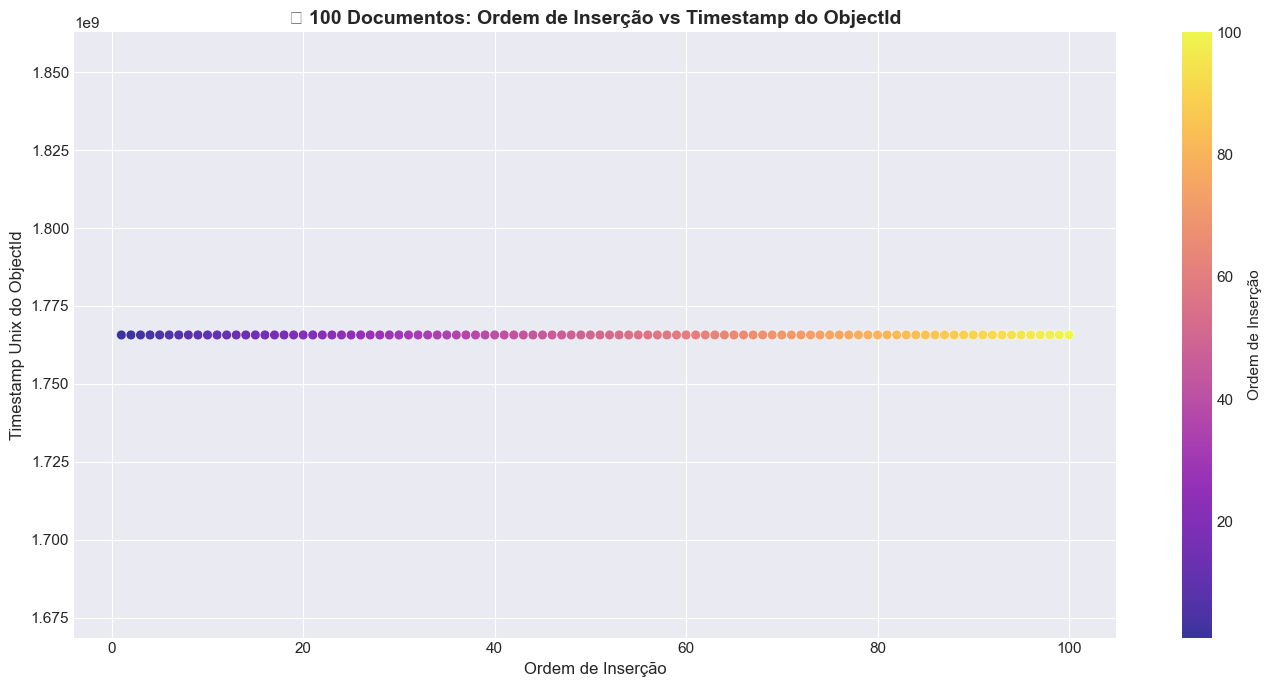


📊 Estatísticas:
   Total de documentos: 100
   Timestamps únicos: 1
   Primeiro timestamp: 2025-12-14 07:51:08+00:00
   Último timestamp: 2025-12-14 07:51:08+00:00


In [8]:
# Visualização 3: Scatter Plot de todas as inserções
fig, ax = plt.subplots(figsize=(14, 7))

scatter = ax.scatter(df_fast['index'], df_fast['generation_time_timestamp'], 
                     c=df_fast['index'], cmap='plasma', s=50, alpha=0.8, edgecolors='white', linewidths=0.5)

ax.set_xlabel('Ordem de Inserção', fontsize=12)
ax.set_ylabel('Timestamp Unix do ObjectId', fontsize=12)
ax.set_title('📊 100 Documentos: Ordem de Inserção vs Timestamp do ObjectId', fontsize=14, fontweight='bold')

plt.colorbar(scatter, label='Ordem de Inserção')
plt.tight_layout()
plt.show()

# Verificar se há timestamps diferentes
unique_timestamps = df_fast['generation_time_timestamp'].nunique()
print(f'\n📊 Estatísticas:')
print(f'   Total de documentos: {len(df_fast)}')
print(f'   Timestamps únicos: {unique_timestamps}')
print(f'   Primeiro timestamp: {df_fast["generation_time"].iloc[0]}')
print(f'   Último timestamp: {df_fast["generation_time"].iloc[-1]}')

---
# Experimento 4: Análise do ObjectId com BSON

Agora vamos usar diretamente o módulo `bson` do PyMongo para analisar os ObjectIds.

In [9]:
from bson import ObjectId
from datetime import datetime, timezone

# Pegar os ObjectIds dos documentos
docs = get_all_documents()

print('🔍 ANÁLISE DETALHADA DOS ObjectIds COM BSON')
print('=' * 70)

for i, doc in enumerate(docs[:5]):  # Primeiros 5
    oid = ObjectId(doc['_id'])
    gen_time = oid.generation_time
    
    print(f"\n📄 Documento {i+1}:")
    print(f"   ObjectId: {oid}")
    print(f"   generation_time (bson): {gen_time}")
    print(f"   Timestamp Unix: {gen_time.timestamp()}")
    print(f"   Hex (primeiros 8 chars = timestamp): {str(oid)[:8]}")

print('\n' + '=' * 70)
print('✅ Os primeiros 8 caracteres hexadecimais do ObjectId representam o timestamp!')

🔍 ANÁLISE DETALHADA DOS ObjectIds COM BSON

📄 Documento 1:
   ObjectId: 693e6c6cdf1e23609fef47fb
   generation_time (bson): 2025-12-14 07:51:08+00:00
   Timestamp Unix: 1765698668.0
   Hex (primeiros 8 chars = timestamp): 693e6c6c

📄 Documento 2:
   ObjectId: 693e6c6cdf1e23609fef47fc
   generation_time (bson): 2025-12-14 07:51:08+00:00
   Timestamp Unix: 1765698668.0
   Hex (primeiros 8 chars = timestamp): 693e6c6c

📄 Documento 3:
   ObjectId: 693e6c6cdf1e23609fef47fd
   generation_time (bson): 2025-12-14 07:51:08+00:00
   Timestamp Unix: 1765698668.0
   Hex (primeiros 8 chars = timestamp): 693e6c6c

📄 Documento 4:
   ObjectId: 693e6c6cdf1e23609fef47fe
   generation_time (bson): 2025-12-14 07:51:08+00:00
   Timestamp Unix: 1765698668.0
   Hex (primeiros 8 chars = timestamp): 693e6c6c

📄 Documento 5:
   ObjectId: 693e6c6cdf1e23609fef47ff
   generation_time (bson): 2025-12-14 07:51:08+00:00
   Timestamp Unix: 1765698668.0
   Hex (primeiros 8 chars = timestamp): 693e6c6c

✅ Os primeiros 8

/var/folders/nn/4459bvg541j38p1n83wq2qm40000gn/T/ipykernel_12020/623893436.py:32: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


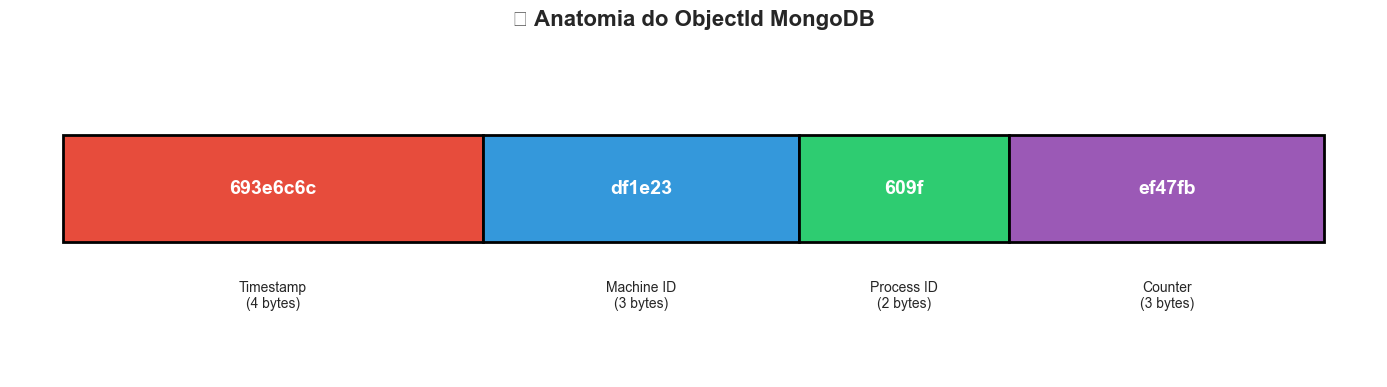


ObjectId completo: 693e6c6cdf1e23609fef47fb
Timestamp extraído: 2025-12-14 07:51:08+00:00


In [10]:
# Visualização 4: Anatomia do ObjectId
from bson import ObjectId

# Criar um ObjectId de exemplo
sample_oid = ObjectId(docs[0]['_id'])
oid_hex = str(sample_oid)

fig, ax = plt.subplots(figsize=(14, 4))

# Desenhar as partes do ObjectId
parts = [
    (oid_hex[0:8], 'Timestamp\n(4 bytes)', '#e74c3c'),
    (oid_hex[8:14], 'Machine ID\n(3 bytes)', '#3498db'),
    (oid_hex[14:18], 'Process ID\n(2 bytes)', '#2ecc71'),
    (oid_hex[18:24], 'Counter\n(3 bytes)', '#9b59b6'),
]

x_pos = 0
for hex_val, label, color in parts:
    width = len(hex_val) * 0.5
    rect = plt.Rectangle((x_pos, 0.3), width, 0.4, facecolor=color, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text(x_pos + width/2, 0.5, hex_val, ha='center', va='center', fontsize=14, fontweight='bold', color='white')
    ax.text(x_pos + width/2, 0.1, label, ha='center', va='center', fontsize=10)
    x_pos += width

ax.set_xlim(-0.5, x_pos + 0.5)
ax.set_ylim(-0.2, 1)
ax.axis('off')
ax.set_title('🔍 Anatomia do ObjectId MongoDB', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f'\nObjectId completo: {oid_hex}')
print(f'Timestamp extraído: {sample_oid.generation_time}')

---
# Conclusão

## ✅ Prova Demonstrada:

1. **ObjectIds contêm timestamps**: Os primeiros 4 bytes (8 caracteres hex) do ObjectId representam o timestamp Unix de quando foi criado.

2. **Documentos inseridos depois têm timestamps mais recentes**: Usando `ObjectId.generation_time` do módulo `bson`, comprovamos que:
   - O primeiro documento inserido tem o timestamp mais antigo
   - O último documento inserido tem o timestamp mais recente

3. **A ordenação por _id é naturalmente cronológica**: Como o timestamp está nos primeiros bytes, ordenar por `_id` é equivalente a ordenar por tempo de criação.

In [11]:
# Resumo final
print('🎉 RESUMO FINAL')
print('=' * 60)

comparison = compare_first_last()

print(f"\n📊 Total de documentos no banco: {len(get_all_documents())}")
print(f"\n🥇 Primeiro ObjectId: {comparison['first_document']['_id']}")
print(f"   Timestamp: {comparison['first_document']['generation_time']}")
print(f"\n🥈 Último ObjectId: {comparison['last_document']['_id']}")
print(f"   Timestamp: {comparison['last_document']['generation_time']}")
print(f"\n⏱️ Diferença: {comparison['time_difference_seconds']:.4f} segundos")
print(f"\n✅ CONCLUSÃO: {comparison['proof']}")

🎉 RESUMO FINAL

📊 Total de documentos no banco: 100

🥇 Primeiro ObjectId: 693e6c6cdf1e23609fef47fb
   Timestamp: 2025-12-14T07:51:08+00:00

🥈 Último ObjectId: 693e6c6cdf1e23609fef485e
   Timestamp: 2025-12-14T07:51:08+00:00

⏱️ Diferença: 0.0000 segundos

✅ CONCLUSÃO: The last inserted ObjectId has a more recent timestamp
